In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from openslide import OpenSlide
from PIL import Image
from collections import defaultdict

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mayo-clinic-strip-ai/sample_submission.csv
/kaggle/input/mayo-clinic-strip-ai/train.csv
/kaggle/input/mayo-clinic-strip-ai/test.csv
/kaggle/input/mayo-clinic-strip-ai/other.csv
/kaggle/input/mayo-clinic-strip-ai/other/314263_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/0b33d7_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/54334d_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/84c279_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/cca9eb_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/880188_1.tif
/kaggle/input/mayo-clinic-strip-ai/other/2e3078_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/9daa03_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/065053_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/8acdfa_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/91530f_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/a2253f_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/f5eb8f_1.tif
/kaggle/input/mayo-clinic-strip-ai/other/ab830f_0.tif
/kaggle/input/mayo-clinic-strip-ai/other/d17ad3_2.tif

In [3]:
train = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')
test = pd.read_csv('../input/mayo-clinic-strip-ai/test.csv')

In [4]:
train_images = glob("/kaggle/input/mayo-clinic-strip-ai/train/*")
test_images = glob("/kaggle/input/mayo-clinic-strip-ai/test/*")
print(f"Number of images in a training set: {len(train_images)}")
print(f"Number of images in a training set: {len(test_images)}")

Number of images in a training set: 754
Number of images in a training set: 4


In [5]:
img_prop = defaultdict(list)

for i, path in enumerate(train_images):
    img_path = train_images[i]
    slide = OpenSlide(img_path)    
    img_prop['image_id'].append(img_path[-12:-4])
    img_prop['width'].append(slide.dimensions[0])
    img_prop['height'].append(slide.dimensions[1])
    img_prop['size'].append(round(os.path.getsize(img_path) / 1e6, 2))
    img_prop['path'].append(img_path)

image_data = pd.DataFrame(img_prop)
image_data['img_aspect_ratio'] = image_data['width']/image_data['height']
image_data.sort_values(by='image_id', inplace=True)
image_data.reset_index(inplace=True, drop=True)

image_data = image_data.merge(train, on='image_id')
image_data.head()

,image_id,width,height,size,path,img_aspect_ratio,center_id,patient_id,image_num,label
0,006388_0,34007,60797,1312.94,/kaggle/input/mayo-clinic-strip-ai/train/00638...,0.559353,11,006388,0,CE
1,008e5c_0,5946,29694,109.57,/kaggle/input/mayo-clinic-strip-ai/train/008e5...,0.200242,11,008e5c,0,CE
2,00c058_0,15255,61801,351.76,/kaggle/input/mayo-clinic-strip-ai/train/00c05...,0.246841,11,00c058,0,LAA
3,01adc5_0,55831,26553,679.17,/kaggle/input/mayo-clinic-strip-ai/train/01adc...,2.102625,11,01adc5,0,LAA
4,026c97_0,10533,8267,61.21,/kaggle/input/mayo-clinic-strip-ai/train/026c9...,1.274102,4,026c97,0,CE


In [6]:
Image.MAX_IMAGE_PIXELS = None
CE_imgs = image_data.loc[image_data['label']=='CE','path']
LAA_imgs = image_data.loc[image_data['label']=='LAA','path']

# Generate & Merge Tiles

Reference:
https://www.kaggle.com/code/analokamus/a-fast-tile-generation
https://www.kaggle.com/code/rftexas/better-image-tiles-removing-white-spaces

In [7]:
import skimage.io as io
import cv2

In [8]:
def load_image(img_path, resize_factor=16):
    img = io.imread(img_path)
    img = cv2.resize(img, dsize=None, fx=1/resize_factor, fy=1/resize_factor)
    return img

In [19]:
def make_tiles(img, tile_size=256, num_tiles=4):
    '''
    img: np.ndarray with dtype np.uint8 and shape (width, height, channel)
    '''
    w, h, ch = img.shape
    pad0, pad1 = (tile_size - w%tile_size) % tile_size, (tile_size - h%tile_size) % tile_size
    padding = [[pad0//2, pad0-pad0//2], [pad1//2, pad1-pad1//2], [0, 0]]
    img = np.pad(img, padding, mode='constant', constant_values=255)
    img = img.reshape(img.shape[0]//tile_size, tile_size, img.shape[1]//tile_size, tile_size, ch)
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, tile_size, tile_size, ch)
    if len(img) < num_tiles: # pad images so that the output shape be the same
        padding = [[0, num_tiles-len(img)], [0, 0], [0, 0], [0, 0]]
        img = np.pad(img, padding, mode='constant', constant_values=255)
    idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))[:num_tiles] # pick up Top N dark tiles
    img = img[idxs]
    return img

In [10]:
def glue_to_one(tiles, window_size=200, k=16):
    side = int(np.sqrt(k))
    image = np.zeros((side*window_size, side*window_size, 3), dtype=np.int16)
        
    for i, patch in enumerate(tiles):
        x = i // side
        y = i % side
        image[
            x * window_size : (x+1) * window_size,
            y * window_size : (y+1) * window_size,
            :
        ] = patch
    
    return image

In [21]:
# 512*512
# tile_size = 128
# tile_num = 16
# tile_size = 64
# tile_num = 64
tile_size = 32
tile_num = 256

**CE**

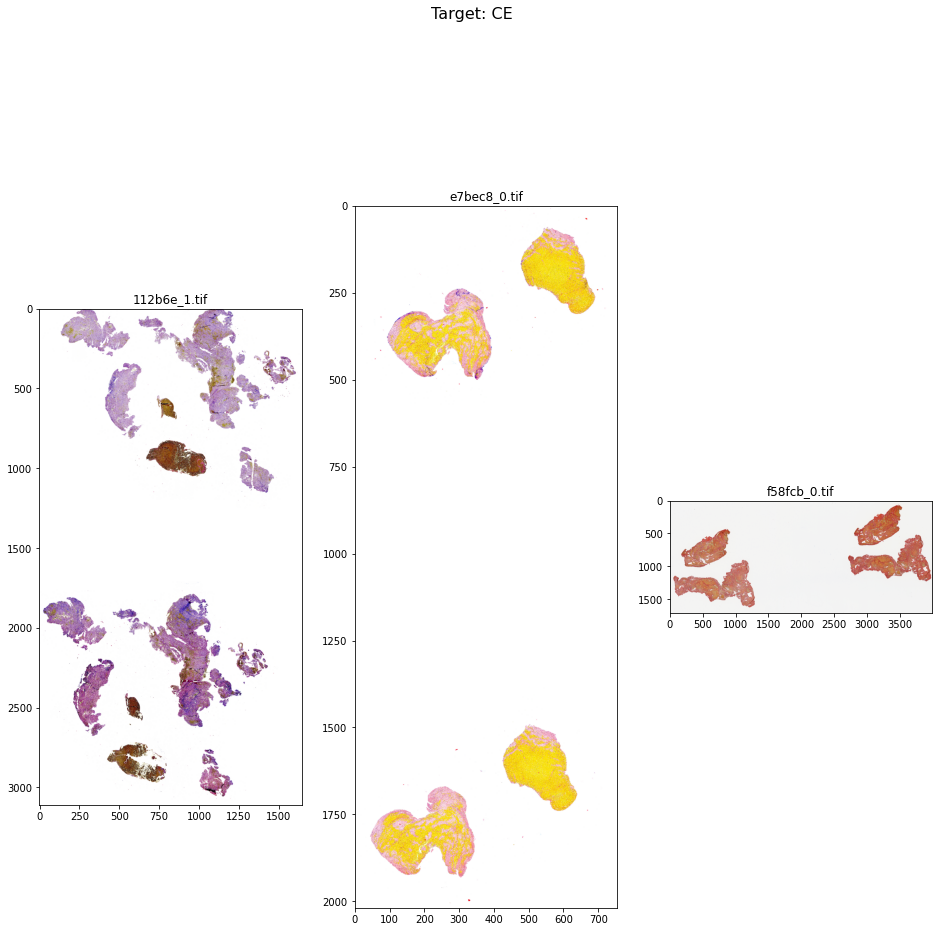

In [12]:
CEs = []
fig, axes = plt.subplots(1,3, figsize=(16,16))
for ax in axes.reshape(-1):
    img_path = np.random.choice(CE_imgs)
    CEs.append(img_path)
    img = load_image(img_path)
    ax.imshow(img), ax.set_title(img_path[-12:])
plt.show()

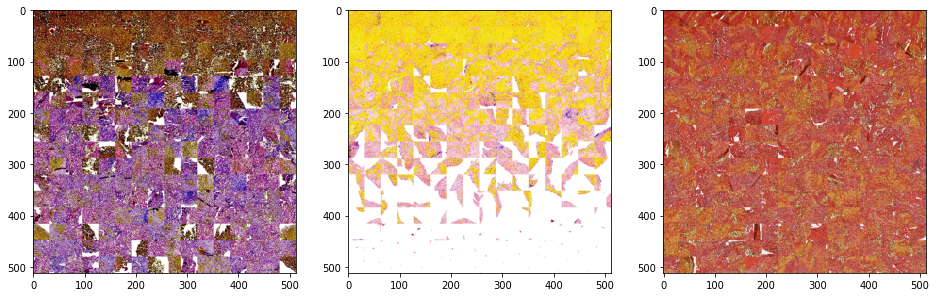

In [22]:
fig, axes = plt.subplots(1,3, figsize=(16,16))
for i in range(3):
    img = load_image(CEs[i])
    tiles = make_tiles(img, tile_size, tile_num)
    glued_img = glue_to_one(tiles, window_size=tile_size, k=tile_num)
    axes[i].imshow(glued_img)
plt.show()

**LAA**

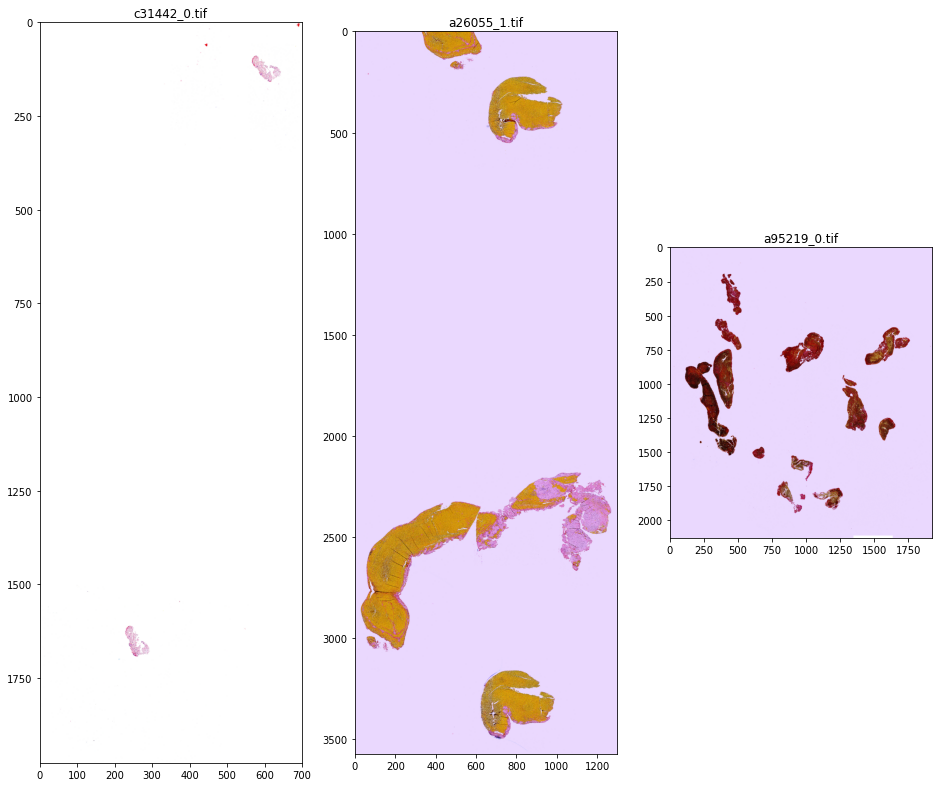

In [14]:
LAAs = []
fig, axes = plt.subplots(1,3, figsize=(16,16))
for ax in axes.reshape(-1):
    img_path = np.random.choice(LAA_imgs)
    LAAs.append(img_path)
    img = load_image(img_path)
    ax.imshow(img), ax.set_title(img_path[-12:])
plt.show()

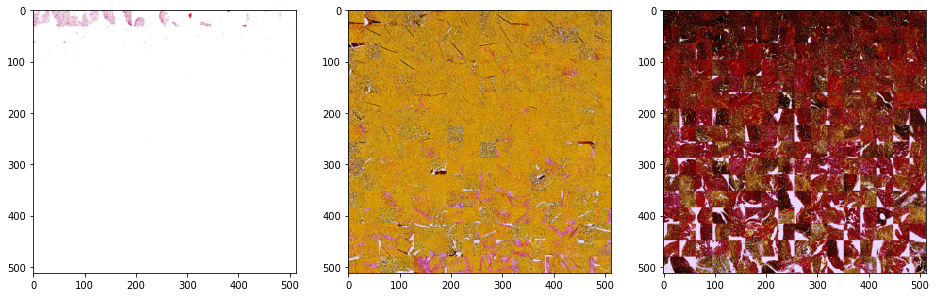

In [23]:
fig, axes = plt.subplots(1,3, figsize=(16,16))
for i in range(3):
    img = load_image(LAAs[i])
    tiles = make_tiles(img, tile_size, tile_num)
    glued_img = glue_to_one(tiles, window_size=tile_size, k=tile_num)
    axes[i].imshow(glued_img)
plt.show()